# Task 1b - Big Data Scenarios - Prof. Meth

In [1]:
import pandas as pd
import csv
import matplotlib.pyplot as plt 

df = pd.read_csv('train_data_w_ingredients.csv', sep=';', error_bad_lines=False, index_col=0)

First look

In [2]:
df.iloc[0]

index                                                          1
name                                         Vietnamese Pho Soup
ingredients    ['8 cups beef broth', '4 cups water', '1 yello...
cuisine                                               Vietnamese
Name: 1, dtype: object

In [3]:
df.head(5)

,index,name,ingredients,cuisine
1,1,Vietnamese Pho Soup,"['8 cups beef broth', '4 cups water', '1 yello...",Vietnamese
2,2,Vietnamese Chicken Meatballs,"['1 pound ground chicken', '3 tablespoons fish...",Vietnamese
3,3,Vietnamese Restaurant-Style Grilled Lemongrass...,"['1 pound pork blade steaks (boneless, about 1...",Vietnamese
4,4,Vietnamese Caramel Chicken,"['1 pound chicken thighs (with skin, deboned)'...",Vietnamese
5,5,Cheater Vietnamese Pho (Pho Bo),"['3 marrow bones (beef bone)', '50 ounces beef...",Vietnamese


In [4]:
print("Document Count")
print(df.groupby('cuisine')['ingredients'].count())

Document Count
cuisine
Chinese       60
Greek         50
Iberic        40
Italian       50
Thai          50
Vietnamese    50
french        50
korean        50
Name: ingredients, dtype: int64


#### Interpretation
Man kann sehen, dass es im Schnitt 50 Rezepte für jede Küchenart gibt. Unsere beiden Küchenarten stechen dabei heraus, da wir 60 Chinesische Rezepte haben und nur 40 ibirische Rezepte.

In [5]:
df.drop(df.loc[301:320].index, inplace=True)

print("Document Count")
print(df.groupby('cuisine')['ingredients'].count())

Document Count
cuisine
Chinese       40
Greek         50
Iberic        40
Italian       50
Thai          50
Vietnamese    50
french        50
korean        50
Name: ingredients, dtype: int64


Damit haben wir unsere Fehler korrigiert. Blöd nur dass es uns jetzt erst aufgefallen ist :(

## Blick auf die Daten

In [6]:
df['ingredients'].iloc[0]

"['8 cups beef broth', '4 cups water', '1 yellow onion (medium, quartered)', '4 cloves garlic (roughly minced)', '3 whole star anise (optional if you don’t like the flavor)', '3 whole cloves (talking about the spice, “cloves”)', '1 ginger (3-inch knob of, sliced into coins)', '1 cinnamon stick', '2 tablespoons fish sauce (optional)', 'salt', 'black pepper', '1 package rice noodles (look for the word “pho” on the package)', '12 ounces steak (very thinly sliced against the grain, I used flank steak)', 'bean sprouts (optional)', 'fresh cilantro (optional)', 'fresh ginger (optional)', 'lime wedges (optional)', 'green onions (optional)', 'jalapenos (optional)', 'thai basil (optional)']"

#### Interpretation
Man kann erkennen das viele Wörter & Symbole unnötig sind (Einheiten, Zahlen, Punctiation). Auch die typischen Stopwords müssen gefiltert werden. Zum verdeutlichen führen wir einen kurzen Test durch indem wir die 30 häufigsten Wörter anschauen

In [7]:
from collections import Counter
df['ingredients'] = df['ingredients']
Counter(" ".join(df["ingredients"]).split()).most_common(30)

[("'1", 1545),
 ("'2", 760),
 ('cup', 705),
 ('teaspoon', 648),
 ('tablespoons', 574),
 ("'1/2", 485),
 ('tablespoon', 425),
 ("'1/4", 312),
 ("'3", 307),
 ('garlic', 262),
 ('cups', 257),
 ("oil',", 248),
 ('and', 230),
 ("sauce',", 215),
 ('1/2', 210),
 ("'4", 209),
 ('fresh', 201),
 ('cloves', 191),
 ('into', 181),
 ('ounces', 179),
 ('red', 179),
 ('teaspoons', 169),
 ('ground', 155),
 ('chicken', 154),
 ("['1", 146),
 ('or', 145),
 ('olive', 142),
 ("salt',", 141),
 ('pound', 139),
 ('onion', 137)]

Die Vermutung lässt also sehr leicht bestätigen indem man die obere Liste betrachtet. 
Nur die nachfolgenden Begriff können alleinstehend als tatsächliche Zutat erkennen:
- garlic
- chicken
- salt
- soy 
- olive

Also gerade einmal 5/30 Zutaten.


# Preprocessing

Erzeugen von drei zusätzlichen Dataframes

In [8]:
#only our cuisines
new_df = df.loc[(df['cuisine'] == 'Chinese') | (df['cuisine'] == 'Iberic')]

new_df.drop(["index"], axis=1, inplace=True)
new_df.drop(["name"], axis=1, inplace=True)
new_df=new_df.reindex(columns=['cuisine','ingredients'])
new_df.head()

/Users/adrianawad/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,cuisine,ingredients
321,Chinese,"['6 chicken thighs (free range)', '2 tablespoo..."
322,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be..."
323,Chinese,"['chicken', '4 boneless skinless chicken breas..."
324,Chinese,['1 1/2 pounds boneless skinless chicken breas...
325,Chinese,"['1 head broccoli (cut into florets)', '3 tabl..."


## Erstellung von Wörterlisten

In [9]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

#Source for list below
#https://en.wikipedia.org/wiki/Cooking_weights_and_measures
#https://thebakingpan.com/ingredient-weights-and-measures/
measures=['teaspoon','teaspoons''cloves','clove','ounces','tablespoons','litrbes','liter','millilitres','mL','grams','gram','g', 'kg','teaspoon','tsp', 'tablespoon','tbsp','fluid', 'ounce','oz','fl.oz', 'cup','pint','pt','quart','qt','gallon','gal','smidgen','drop','pinch','dash','scruple','dessertspoon','teacup','cup','cups','c','pottle','gill','dram','wineglass','coffeespoon','pound','pounded','lb','tbsp','plus','firmly', 'packed','lightly','level','even','rounded','heaping','heaped','sifted','bushel','peck','stick','chopped','sliced','halves', 'shredded','slivered','sliced','whole','paste','whole',' fresh', 'peeled', 'diced','mashed','dried','frozen','fresh','peeled','candied','no', 'pulp','crystallized','canned','crushed','minced','julienned','clove','head', 'small','large','medium', 'torn', 'cleaned', 'degree']

#measures = [lemmatizer.lemmatize(m) for m in measures]
#some of these include data leakage words, like 'italian' - ok to remove after including bigrams
data_leaks = ['iberic','greek', 'korean','italianstyle', 'french','thai', 'chinese', 'mexican','spanish','indian','italian']

common_remove=['fine','ground','to','taste', 'and', 'or','back'  'can',  'into', 'cut', 'grated', 'leaf','package','finely','divided','a','piece','optional','inch','needed','more','drained','for','flake','dry','thinly','cubed','bunch','cube','slice','pod','beaten','seeded','uncooked','root','plain','heavy','halved','crumbled','sweet','with','hot','room','temperature','trimmed','allpurpose','deveined','bulk','seasoning','jar','food','if','bag','mix','in','each','roll','instant','double','such','frying','thawed','whipping','stock','rinsed','mild','sprig','freshly','toasted','link','boiling','cooked','unsalted','container',
'cooking','thin','lengthwise','warm','softened','thick','quartered','juiced','pitted','chunk','melted','cold','coloring','puree','cored','stewed','floret','coarsely','the','blanched','zested','sweetened','powdered','garnish','dressing','soup','at','active','lean','chip','sour','long','ripe','skinned','fillet','from','stem','flaked','removed','stalk','unsweetened','cover','crust', 'extra', 'prepared', 'blend', 'of', 'ring',  'undrained', 'about', 'zest', ' ', '', 'spray', 'round', 'herb', 'seasoned', 'wedge', 'bitesize', 'broken', 'square', 'freshly', 'thickly', 'diagonally']
#common_remove = [lemmatizer.lemmatize(c) for c in common_remove]
#data_leaks = [lemmatizer.lemmatize(d) for d in data_leaks]
# due to using bigrams not including 

useless_singles=['reduced','sodium','new','milliliter','milliliters','seeds','seed','breast', 'breasts','teaspoons','teaspoon','oil','black','white','red','yellow','seed','breast','confectioner','sundried','broth','bell','baby','juice','crumb','sauce','condensed','smoked','basmati','extravirgin','brown','clarified', 'filling', 'pine', 'virgin', 'romano', 'heart', 'shell', 'thigh', 'boneless','skinless','split', 'dark', 'wheat', 'light', 'green', 'vegetable', 'curry', 'orange', 'garam', 'strip', 'sea', 'canola', 'mustard','powder', 'ice', 'bay', 'roasted', 'loaf', 'roast', 'powder']
#useless_singles = [lemmatizer.lemmatize(u) for u in useless_singles]

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adrianawad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing

In [10]:
def remove_unwanted(i):
    cl = i.strip('[]')
    return cl

new_df['ingredients_list'] = new_df['ingredients'].map(lambda s:remove_unwanted(s).split(","))
new_df.head(1)

,cuisine,ingredients,ingredients_list
321,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo..."


In [11]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()

def preprocess(sentence):
    sentence=str(sentence) #stringify
    sentence = sentence.lower() #kleinschreibung
    sentence = re.sub("\(.*?\)","()",sentence) #Alternativen entfernen - also alles zwischen ( )
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words] 
    lemma_words = [w for w in lemma_words if not w in measures]
    lemma_words = [w for w in lemma_words if not w in data_leaks]
    lemma_words = [w for w in lemma_words if not w in common_remove]
    lemma_words = [w for w in lemma_words if not w in useless_singles]
    
    return " ".join(lemma_words)


# Apply to the DF series
new_df['cleanText']=new_df['ingredients'].map(lambda s:preprocess(s)) 
new_df['cleanTextList']=new_df['ingredients'].map(lambda s:preprocess(s).split()) 
new_df.head(3)

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList
321,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo...",chicken olive ginger garlic honey soy sesame,"[chicken, olive, ginger, garlic, honey, soy, s..."
322,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg onion carrot pea garlic ginger rice...,"[butter, egg, onion, carrot, pea, garlic, ging..."
323,Chinese,"['chicken', '4 boneless skinless chicken breas...","['chicken', '4 boneless skinless chicken brea...",chicken chicken egg cornstarch flour sugar ric...,"[chicken, chicken, egg, cornstarch, flour, sug..."


### Generate Bigrams

In [12]:
new_df['bigrams'] = new_df['cleanText'].apply(lambda row: list(nltk.bigrams(row.split(' '))))
new_df.head()

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList,bigrams
321,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo...",chicken olive ginger garlic honey soy sesame,"[chicken, olive, ginger, garlic, honey, soy, s...","[(chicken, olive), (olive, ginger), (ginger, g..."
322,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg onion carrot pea garlic ginger rice...,"[butter, egg, onion, carrot, pea, garlic, ging...","[(butter, egg), (egg, onion), (onion, carrot),..."
323,Chinese,"['chicken', '4 boneless skinless chicken breas...","['chicken', '4 boneless skinless chicken brea...",chicken chicken egg cornstarch flour sugar ric...,"[chicken, chicken, egg, cornstarch, flour, sug...","[(chicken, chicken), (chicken, egg), (egg, cor..."
324,Chinese,['1 1/2 pounds boneless skinless chicken breas...,['1 1/2 pounds boneless skinless chicken breas...,chicken cornstarch flour baking water salt egg...,"[chicken, cornstarch, flour, baking, water, sa...","[(chicken, cornstarch), (cornstarch, flour), (..."
325,Chinese,"['1 head broccoli (cut into florets)', '3 tabl...","['1 head broccoli (cut into florets)', '3 tab...",broccoli chicken garlic spring onion ginger ho...,"[broccoli, chicken, garlic, spring, onion, gin...","[(broccoli, chicken), (chicken, garlic), (garl..."


# Task 1b/a

## Task 1b/a Absolute number of ingredients

In [13]:
def count_ingredients (i):
    num = len(i)
    return num

new_df['number of ingredients'] = new_df['ingredients_list'].apply(count_ingredients)
new_df['CLEAN number of ingredients'] = new_df['cleanTextList'].apply(count_ingredients)
new_df.sample(5)

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList,bigrams,number of ingredients,CLEAN number of ingredients
351,Chinese,"['2 skinless chicken breasts (boneless)', '2 t...","['2 skinless chicken breasts (boneless)', '2 ...",chicken soy sesame pepper romaine lettuce cabb...,"[chicken, soy, sesame, pepper, romaine, lettuc...","[(chicken, soy), (soy, sesame), (sesame, peppe...",17,22
362,Iberic,"['2 1/2 pounds chourico (Ground, You can groun...","['2 1/2 pounds chourico (Ground, You can grou...",chourico salted butter garlic onion beer tomat...,"[chourico, salted, butter, garlic, onion, beer...","[(chourico, salted), (salted, butter), (butter...",10,8
349,Chinese,"['1 cup medium grain rice (uncooked)', '1 tabl...","['1 cup medium grain rice (uncooked)', '1 tab...",grain rice sesame onion garlic turkey chili ga...,"[grain, rice, sesame, onion, garlic, turkey, c...","[(grain, rice), (rice, sesame), (sesame, onion...",12,14
369,Iberic,"['1/4 cup olive oil', '3 red bell peppers (ste...","['1/4 cup olive oil', '3 red bell peppers (st...",olive pepper onion garlic pepper chili paprika...,"[olive, pepper, onion, garlic, pepper, chili, ...","[(olive, pepper), (pepper, onion), (onion, gar...",29,31
355,Chinese,"['1 pound flank steak (or top sirloin steak)',...","['1 pound flank steak (or top sirloin steak)',...",flank steak cornstarch garlic ginger low soy w...,"[flank, steak, cornstarch, garlic, ginger, low...","[(flank, steak), (steak, cornstarch), (cornsta...",12,13


In [14]:
chinese = new_df.loc[(df['cuisine'] == 'Chinese')]
iberic = new_df.loc[(df['cuisine'] == 'Iberic')]

## Result:

### Chinese & Iberic

In [15]:
Total = new_df['number of ingredients'].sum()
Total

1022

### Only chinese

In [16]:
chineseTotal = chinese['number of ingredients'].sum()
chineseTotal

537

### Only iberic

In [17]:
ibericTotal = iberic['number of ingredients'].sum()
ibericTotal

485

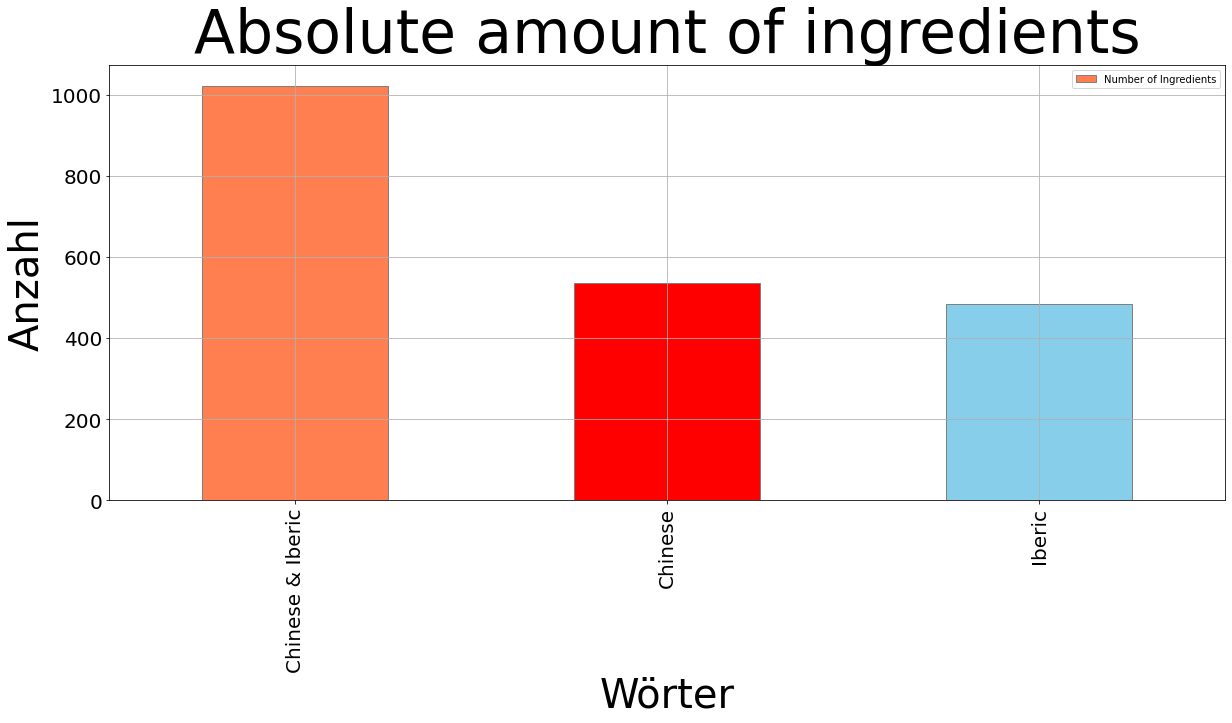

In [18]:
num = {'Cuisine': ['Chinese & Iberic', 'Chinese','Iberic'],
                   'Number of Ingredients': [Total, chineseTotal, ibericTotal]}
TotalIngredients = pd.DataFrame(num, columns= ['Cuisine', 'Number of Ingredients'])

barlist = TotalIngredients.plot.bar(x='Cuisine',
         y='Number of Ingredients', 
         color=['coral','red','skyblue'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Absolute amount of ingredients', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Total number of Ingredients.png', bbox_inches = 'tight')
plt.show()

## Task 1b/b Relative number of different ingredients

In [19]:
print('Ingredients List:')
print(new_df['ingredients_list'].iloc[0])
print('Anzahl:')
print(len(new_df['ingredients_list'].iloc[0]))
print()
print('After cleanup:')
print(new_df['cleanTextList'].iloc[0])
print('Anzahl:')
print(len(new_df['cleanTextList'].iloc[0]))

Ingredients List:
["'6 chicken thighs (free range)'", " '2 tablespoons olive oil'", " '1/2 teaspoon minced ginger'", " '2 cloves minced garlic'", " '3 tablespoons honey'", " '2 tablespoons dark soy sauce'", " '2 teaspoons sesame seeds'", " 'seasoning'"]
Anzahl:
8

After cleanup:
['chicken', 'olive', 'ginger', 'garlic', 'honey', 'soy', 'sesame']
Anzahl:
7


Man sieht das nach dem aufräumen die Zutatliste deutlich anders aussieht. Die Anhzahl der Zutaten selbst hat sich auch deutlich verändert. Das liegt an den Zutaten die aus zwei Wörtern bestehen. In unserem Beispiel "corn starch" wird nach dem cleanup zu "corn", "starch".

Dennoch ist es sinnvoll mit den bereinigten Zutaten zu arbeiten, da die Bestimmung von unterschiedlichen Zutaten auf Basis der unbereinigten Zutaten zu Problem führt: 

- Die Anzahl der Zutaten, also z.B. 2 oder 1 würde als unterschiedliche Zutat beurteilt werden.
- Die Zutaten selbst könnten durch unterschiedliche Einheiten nicht als gleich identifiziert werden (Cups vs tablespoons)

## Result:

In [20]:
TotalClean = new_df['CLEAN number of ingredients'].sum()
TotalCleanChinese = chinese['CLEAN number of ingredients'].sum()
TotalCleanIberic = iberic['CLEAN number of ingredients'].sum()
print('Absolut number Chinese & Iberic: ' + str(TotalClean))
print()
print('Absolut number Chinese: ' + str(TotalCleanChinese))
print()
print('Absolut number Iberic: ' + str(TotalCleanIberic))

Absolut number Chinese & Iberic: 1022

Absolut number Chinese: 535

Absolut number Iberic: 487


In [21]:
#Chinese & Iberic
results = Counter()
new_df['cleanTextList'].apply(results.update)

#Chinese
resultsChinese = Counter()
chinese['cleanTextList'].apply(resultsChinese.update)

#Iberic
resultsIberic = Counter()
iberic['cleanTextList'].apply(resultsIberic.update)

print('Different Ingredients Chinese & Iberic: ' + str(len(results)))
print()
print('Different Ingredients Chinese: ' + str(len(resultsChinese)))
print()
print('Different Ingredients Iberic: ' + str(len(resultsIberic)))

Different Ingredients Chinese & Iberic: 184

Different Ingredients Chinese: 98

Different Ingredients Iberic: 131


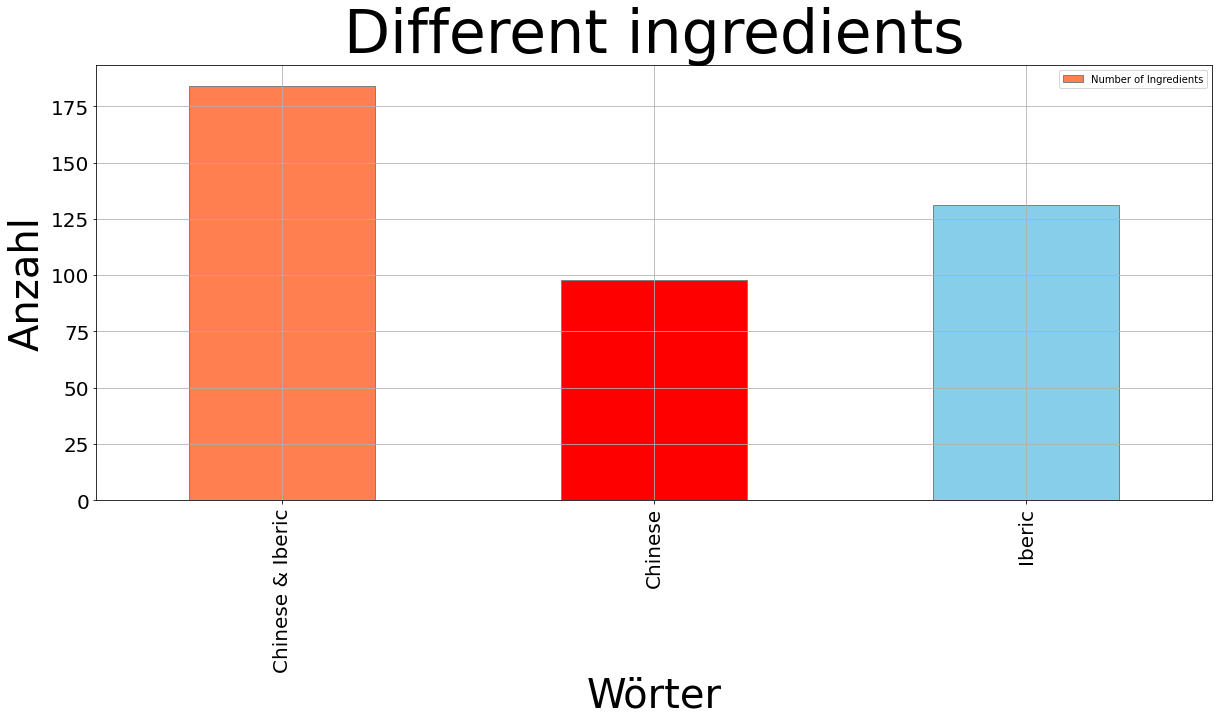

In [49]:
num = {'Cuisine': ['Chinese & Iberic', 'Chinese','Iberic'],
                   'Number of Ingredients': [len(results), len(resultsChinese), len(resultsIberic)]}
TotalIngredients = pd.DataFrame(num, columns= ['Cuisine', 'Number of Ingredients'])

barlist = TotalIngredients.plot.bar(x='Cuisine',
         y='Number of Ingredients', 
         color=['coral','red','skyblue'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Different ingredients', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Relativ number of Ingredients.png', bbox_inches = 'tight')
plt.show()

## Absolute number of different ingredients / Absolute number of ingredients

#### Chinese & Iberic

In [23]:
a = TotalClean/len(results)
print(a)
print()
print(results)

5.554347826086956

Counter({'garlic': 61, 'pepper': 52, 'salt': 50, 'onion': 47, 'soy': 41, 'chicken': 38, 'olive': 35, 'egg': 33, 'rice': 31, 'sugar': 31, 'water': 28, 'ginger': 26, 'sesame': 20, 'tomato': 19, 'vinegar': 18, 'cornstarch': 17, 'wine': 16, 'carrot': 14, 'bean': 14, 'paprika': 14, 'flour': 13, 'lemon': 12, 'honey': 11, 'oregano': 11, 'chili': 10, 'potato': 10, 'cabbage': 9, 'broccoli': 8, 'butter': 7, 'hoisin': 7, 'sprout': 7, 'pork': 7, 'low': 7, 'cilantro': 7, 'cumin': 7, 'pea': 6, 'scallion': 6, 'peanut': 6, 'fish': 6, 'granulated': 6, 'chorizo': 6, 'milk': 6, 'oyster': 5, 'sausage': 5, 'grain': 5, 'kosher': 5, 'parsley': 5, 'noodle': 4, 'beef': 4, 'napa': 4, 'mushroom': 4, 'sherry': 4, 'purpose': 4, 'cinnamon': 4, 'sriracha': 3, 'baking': 3, 'spring': 3, 'chow': 3, 'mein': 3, 'sirloin': 3, 'steak': 3, 'turmeric': 3, 'handful': 3, 'corn': 3, 'starch': 3, 'shrimp': 3, 'shallot': 3, 'bread': 3, 'jalapeno': 3, 'cheese': 3, 'thyme': 3, 'rib': 2, 'spice': 2, 'shaoxing': 2,

### Only chinese

In [24]:
c = TotalCleanChinese/len(resultsChinese)
print(c)
print()
print(resultsChinese)

5.459183673469388

Counter({'soy': 41, 'garlic': 32, 'chicken': 27, 'ginger': 26, 'onion': 24, 'egg': 21, 'rice': 21, 'sesame': 18, 'sugar': 18, 'water': 18, 'pepper': 18, 'cornstarch': 17, 'vinegar': 16, 'salt': 15, 'carrot': 12, 'honey': 10, 'flour': 8, 'wine': 8, 'broccoli': 8, 'cabbage': 8, 'bean': 8, 'hoisin': 7, 'sprout': 7, 'peanut': 6, 'pea': 5, 'chili': 5, 'oyster': 5, 'scallion': 5, 'noodle': 4, 'pork': 4, 'napa': 4, 'mushroom': 4, 'low': 4, 'olive': 3, 'sriracha': 3, 'spring': 3, 'chow': 3, 'mein': 3, 'sirloin': 3, 'steak': 3, 'beef': 3, 'granulated': 3, 'sherry': 3, 'corn': 3, 'starch': 3, 'butter': 2, 'baking': 2, 'spice': 2, 'turmeric': 2, 'shaoxing': 2, 'shiitake': 2, 'wrapper': 2, 'fish': 2, 'chilli': 2, 'lemon': 2, 'shrimp': 2, 'substitute': 2, 'back': 1, 'rib': 1, 'five': 1, 'stir': 1, 'fry': 1, 'paprika': 1, 'jasmine': 1, 'bbq': 1, 'sausage': 1, 'chive': 1, 'handful': 1, 'ketchup': 1, 'apple': 1, 'cider': 1, 'belly': 1, 'caster': 1, 'grass': 1, 'wing': 1, 'color': 1,

### Only iberic

In [25]:
i = TotalCleanIberic/len(resultsIberic)
print(i)
print()
print(resultsIberic)

3.717557251908397

Counter({'salt': 35, 'pepper': 34, 'olive': 32, 'garlic': 29, 'onion': 23, 'tomato': 18, 'sugar': 13, 'paprika': 13, 'egg': 12, 'chicken': 11, 'oregano': 11, 'potato': 10, 'water': 10, 'lemon': 10, 'rice': 10, 'wine': 8, 'cumin': 7, 'bean': 6, 'chorizo': 6, 'milk': 6, 'cilantro': 6, 'butter': 5, 'flour': 5, 'parsley': 5, 'chili': 5, 'sausage': 4, 'cinnamon': 4, 'fish': 4, 'kosher': 4, 'grain': 4, 'granulated': 3, 'purpose': 3, 'shallot': 3, 'bread': 3, 'jalapeno': 3, 'cheese': 3, 'thyme': 3, 'pork': 3, 'low': 3, 'carrot': 2, 'kale': 2, 'kidney': 2, 'salted': 2, 'celery': 2, 'linguica': 2, 'pinto': 2, 'kilogram': 2, 'basil': 2, 'yeast': 2, 'port': 2, 'handful': 2, 'vinegar': 2, 'sesame': 2, 'salsa': 2, 'lime': 2, 'vanilla': 2, 'fat': 2, 'andouille': 1, 'butternut': 1, 'squash': 1, 'chourico': 1, 'beer': 1, 'tabasco': 1, 'baking': 1, 'cake': 1, 'lard': 1, 'cream': 1, 'yolk': 1, 'bacon': 1, 'fire': 1, 'ricotta': 1, 'cheddar': 1, 'parmesan': 1, 'rustic': 1, 'kalamata': 1

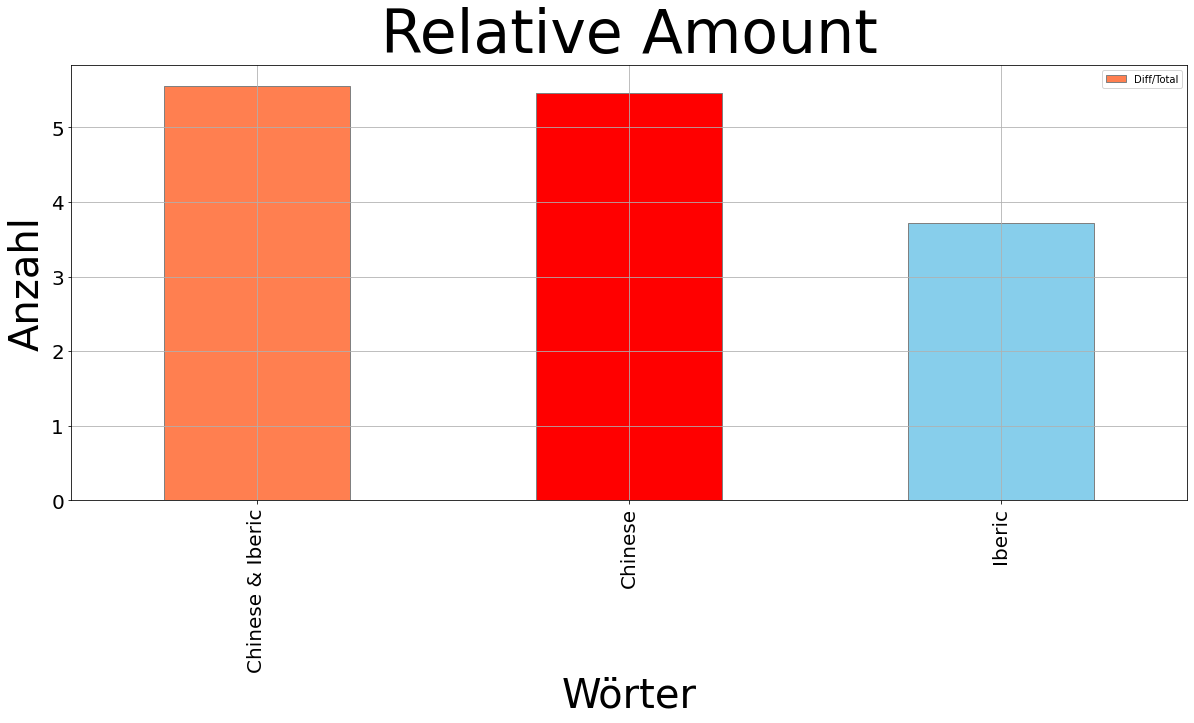

In [51]:
num = {'Cuisine': ['Chinese & Iberic', 'Chinese','Iberic'],
                   'Diff/Total': [a, c, i]}
TotalIngredients = pd.DataFrame(num, columns= ['Cuisine', 'Diff/Total'])

barlist = TotalIngredients.plot.bar(x='Cuisine',
         y='Diff/Total', 
         color=['coral','red','skyblue'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Relative Amount', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Relative Amount.png', bbox_inches = 'tight')
plt.show()

## Task 1b/c Top 10 most frequent ingredients

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(new_df['cleanText'], 10)
chinese_common_words = get_top_n_words(chinese['cleanText'], 10)
iberic_common_words = get_top_n_words(iberic['cleanText'], 10)

df1 = pd.DataFrame(common_words, columns = ['Ingredient' , 'Count'])
df1c = pd.DataFrame(chinese_common_words, columns = ['IngredientChinese' , 'CountChinese'])
df1i = pd.DataFrame(iberic_common_words, columns = ['IngredientIberic' , 'CountIberic'])

most_frequent_single = pd.concat([df1, df1c, df1i ], axis=1)


most_frequent_single.head(10)

,Ingredient,Count,IngredientChinese,CountChinese,IngredientIberic,CountIberic
0,garlic,61,soy,41,salt,35
1,pepper,52,garlic,32,pepper,34
2,salt,50,chicken,27,olive,32
3,onion,47,ginger,26,garlic,29
4,soy,41,onion,24,onion,23
5,chicken,38,egg,21,tomato,18
6,olive,35,rice,21,sugar,13
7,egg,33,sesame,18,paprika,13
8,rice,31,sugar,18,egg,12
9,sugar,31,water,18,chicken,11


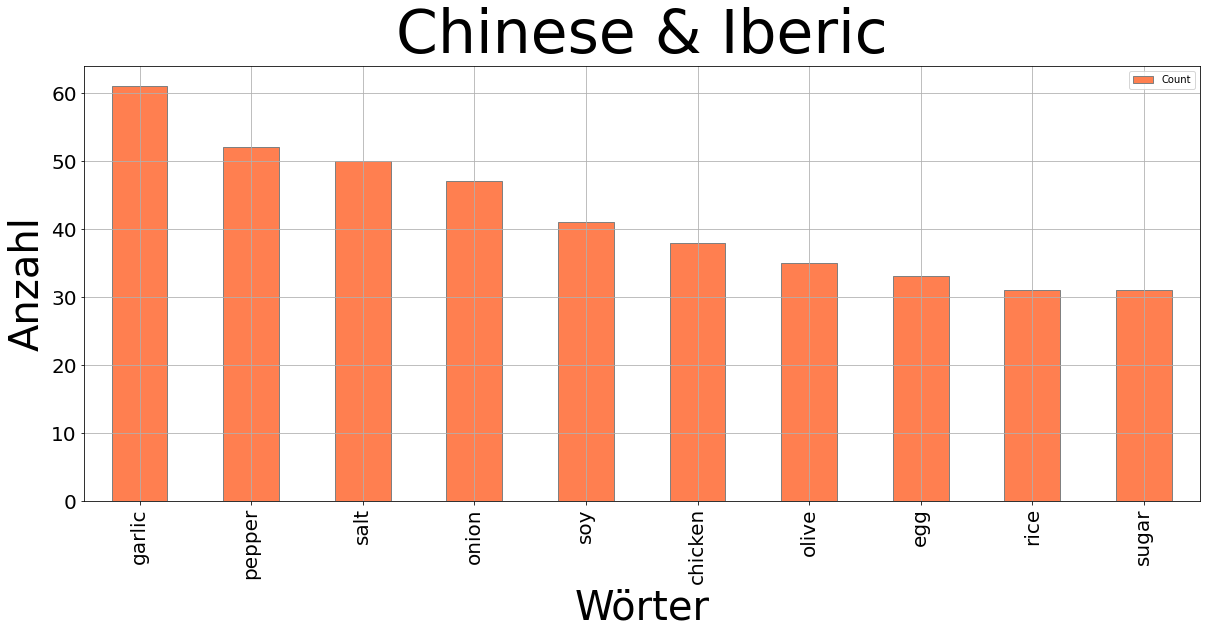

In [28]:
df1.plot.bar(x='Ingredient',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Single Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

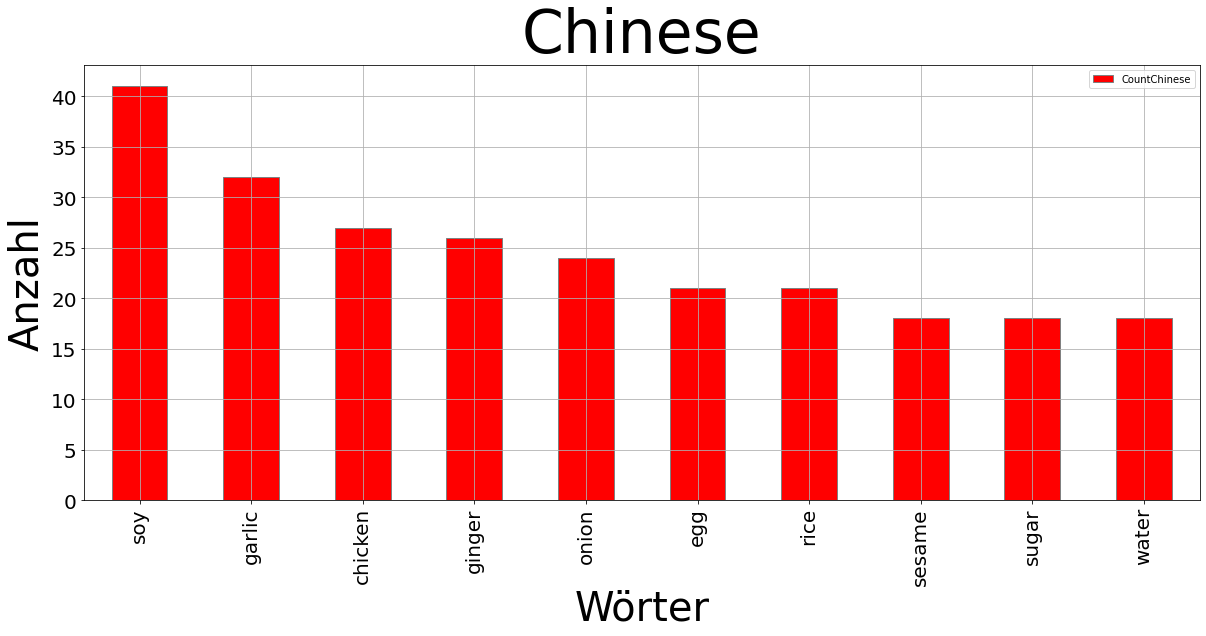

In [29]:
df1c.plot.bar(x='IngredientChinese',
         y='CountChinese', 
         color=['red'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Single Chinese.png', bbox_inches = 'tight')
plt.show()

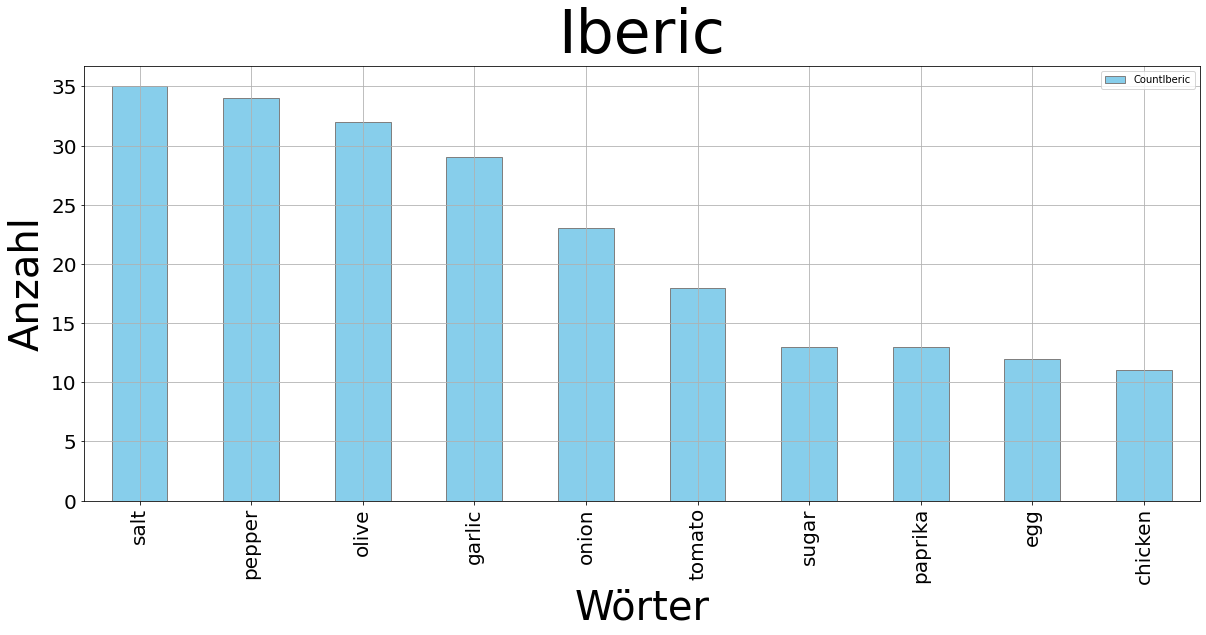

In [30]:
df1i.plot.bar(x='IngredientIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Single Iberic.png', bbox_inches = 'tight')
plt.show()

## Task 1b/c Top 10 most frequent bigrams

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_bigram(new_df['cleanText'], 10)
chinese_common_words = get_top_n_bigram(chinese['cleanText'], 10)
iberic_common_words = get_top_n_bigram(iberic['cleanText'], 10)

df2 = pd.DataFrame(common_words, columns = ['Ingredient' , 'Count'])
df2c = pd.DataFrame(chinese_common_words, columns = ['IngredientChinese' , 'CountChinese'])
df2i = pd.DataFrame(iberic_common_words, columns = ['IngredientIberic' , 'CountIberic'])

most_frequent_bigram = pd.concat([df2, df2c, df2i ], axis=1)


most_frequent_bigram.head(10)

,Ingredient,Count,IngredientChinese,CountChinese,IngredientIberic,CountIberic
0,salt pepper,19,soy sesame,9,salt pepper,15
1,onion garlic,11,ginger garlic,8,onion garlic,8
2,soy sesame,9,garlic ginger,8,paprika oregano,6
3,ginger garlic,8,rice vinegar,8,onion pepper,5
4,garlic ginger,8,bean sprout,7,garlic olive,4
5,rice vinegar,8,rice wine,6,tomato salt,4
6,bean sprout,7,cornstarch flour,5,kosher salt,4
7,rice wine,6,wine vinegar,5,oregano salt,4
8,onion pepper,6,soy water,5,olive salt,4
9,paprika oregano,6,vinegar soy,4,grain rice,4


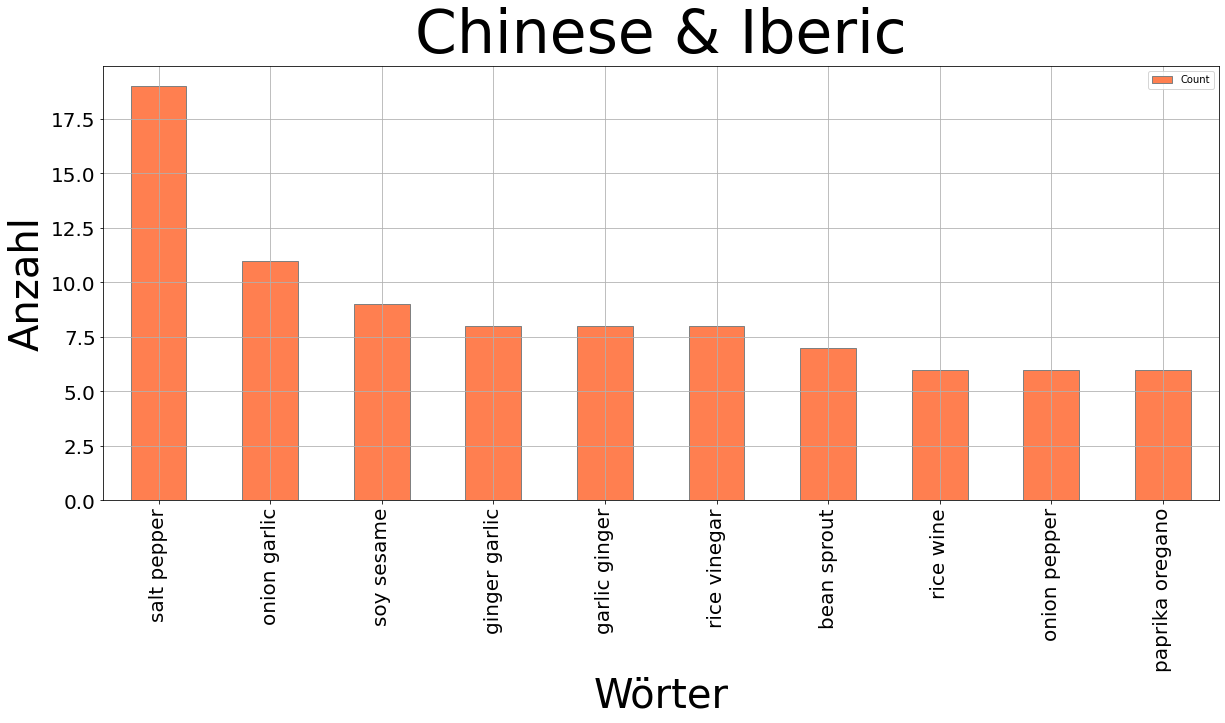

In [32]:
df2.plot.bar(x='Ingredient',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 bigram Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

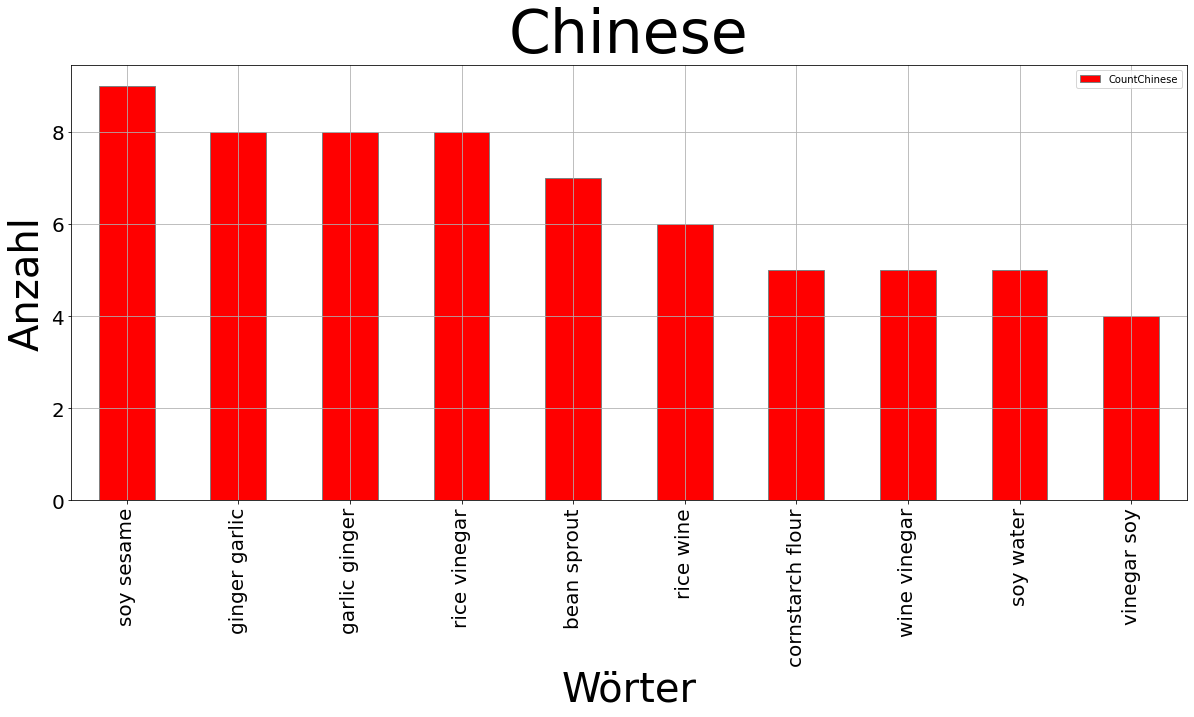

In [33]:
df2c.plot.bar(x='IngredientChinese',
         y='CountChinese', 
         color=['red'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 bigram Chinese.png', bbox_inches = 'tight')
plt.show()

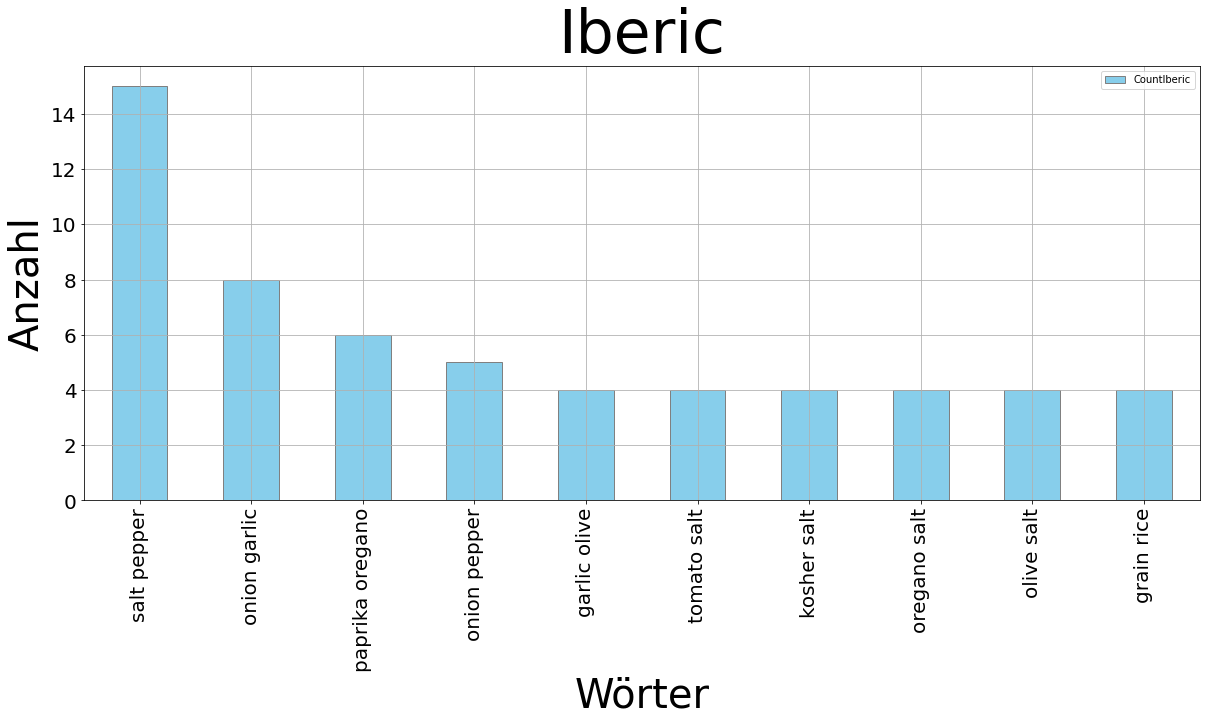

In [34]:
df2i.plot.bar(x='IngredientIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic', fontsize=60)
plt.xlabel('Wörter', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 bigram Iberic.png', bbox_inches = 'tight')
plt.show()

## Task 1b/d Top 10 most frequent ingredient combinations single

In [35]:
import itertools


def generate_combinations (a_list):
    combinations =[]
    
    for i in a_list:
        for pair in itertools.combinations(i,2):
            combinations.append(pair)
            
    return Counter(elem[0:2] for elem in combinations)

In [36]:
ac = generate_combinations(new_df['cleanTextList'])
cc = generate_combinations(chinese['cleanTextList'])
ic = generate_combinations(iberic['cleanTextList'])

df3 = pd.DataFrame.from_records(ac.most_common(10), columns=['Combination','Count'])
df3c = pd.DataFrame.from_records(cc.most_common(10), columns=['CombinationChinese','CountChinese'])
df3i = pd.DataFrame.from_records(ic.most_common(10), columns=['CombinationIberic','CountIberic'])

most_frequent_single_combination = pd.concat([df3, df3c, df3i ], axis=1)

most_frequent_single_combination.head(10)

,Combination,Count,CombinationChinese,CountChinese,CombinationIberic,CountIberic
0,"(garlic, salt)",34,"(garlic, soy)",27,"(onion, pepper)",28
1,"(onion, pepper)",34,"(chicken, soy)",23,"(olive, salt)",26
2,"(onion, garlic)",30,"(chicken, garlic)",19,"(garlic, salt)",26
3,"(garlic, soy)",27,"(ginger, soy)",18,"(pepper, salt)",22
4,"(salt, pepper)",27,"(chicken, cornstarch)",18,"(onion, salt)",21
5,"(pepper, salt)",27,"(chicken, ginger)",17,"(salt, pepper)",21
6,"(garlic, pepper)",27,"(soy, sesame)",17,"(olive, pepper)",20
7,"(olive, salt)",26,"(chicken, sugar)",17,"(onion, garlic)",20
8,"(onion, salt)",24,"(soy, water)",17,"(garlic, pepper)",20
9,"(chicken, soy)",23,"(garlic, ginger)",16,"(garlic, olive)",19


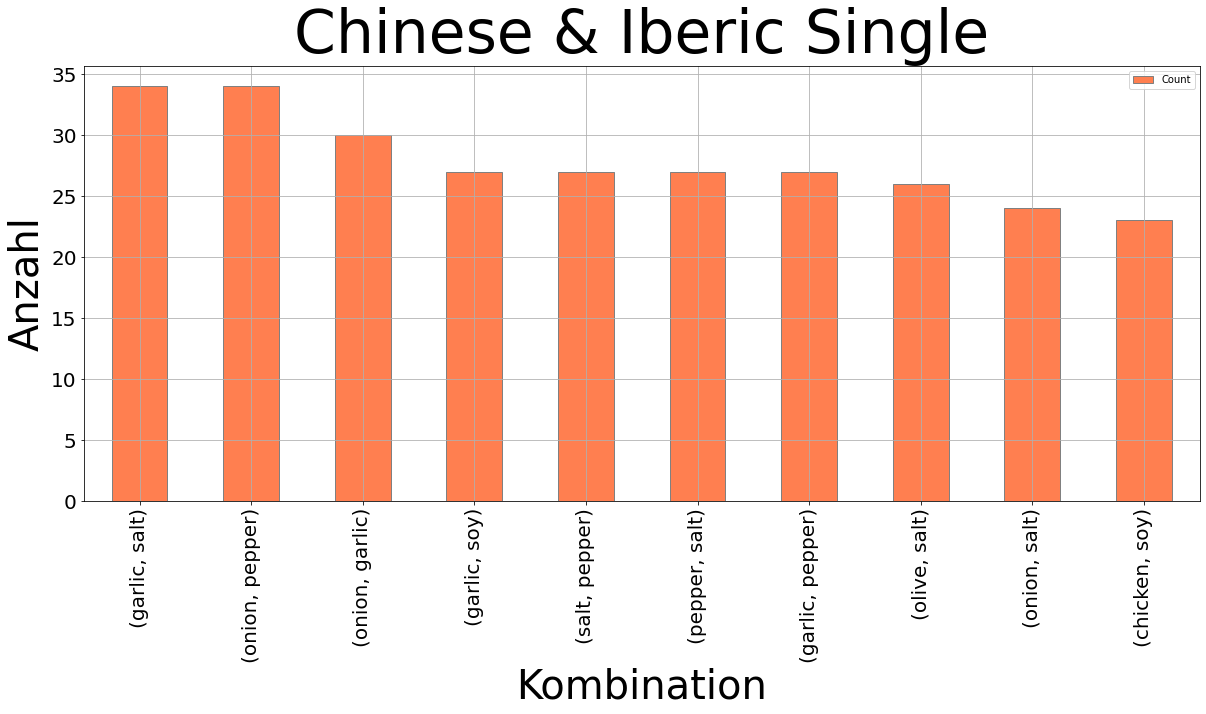

In [37]:
df3.plot.bar(x='Combination',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic Single', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination single Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

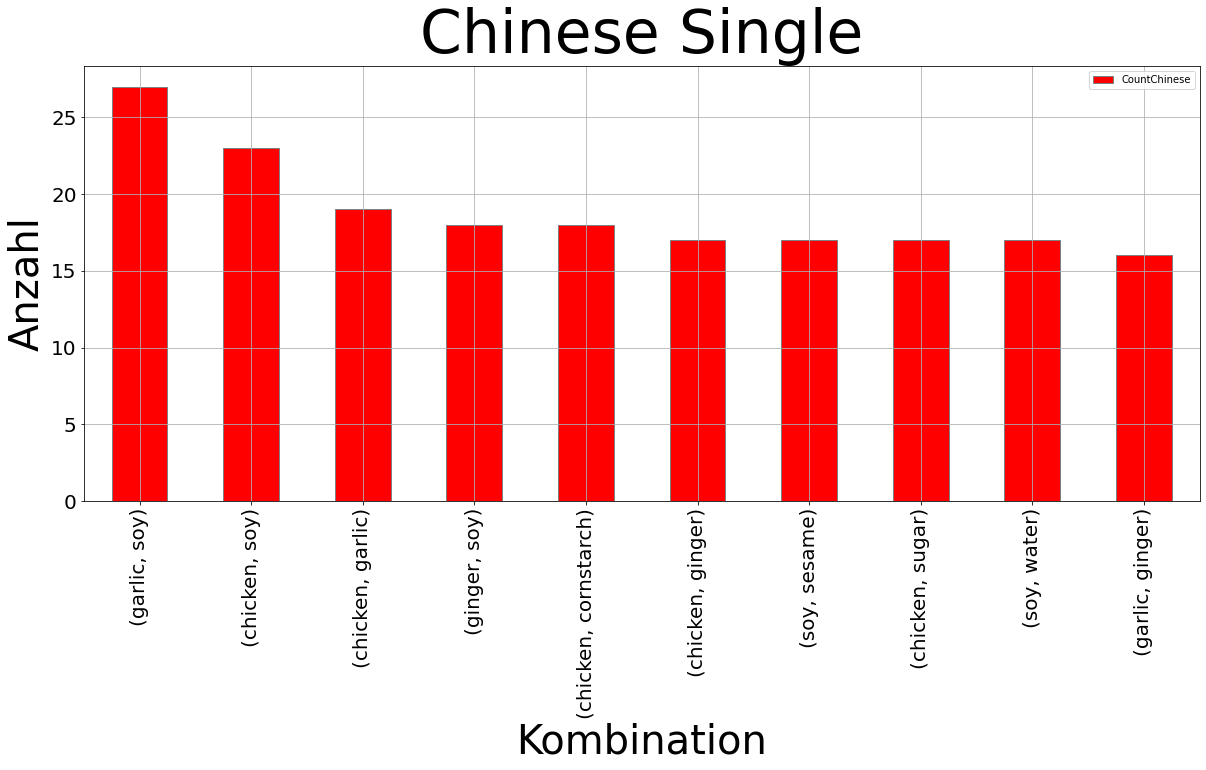

In [38]:
df3c.plot.bar(x='CombinationChinese',
         y='CountChinese', 
         color=['red'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese Single', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination single Chinese.png', bbox_inches = 'tight')
plt.show()

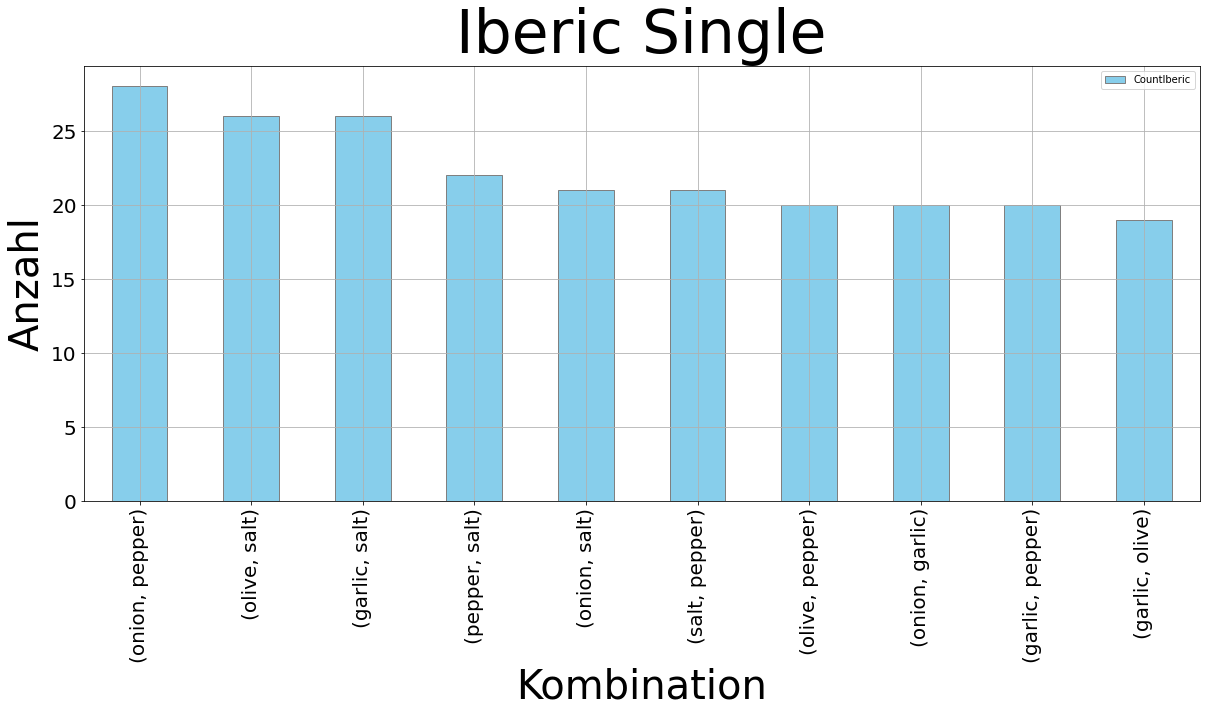

In [39]:
df3i.plot.bar(x='CombinationIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic Single', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination single Iberic.png', bbox_inches = 'tight')
plt.show()

## Task 1b/d Top 10 most frequent ingredient combinations bigrams

In [40]:
abc = generate_combinations(new_df['bigrams'])
cbc = generate_combinations(chinese['bigrams'])
ibc = generate_combinations(iberic['bigrams'])

df4 = pd.DataFrame.from_records(abc.most_common(10), columns=['Combination','Count'])
df4c = pd.DataFrame.from_records(cbc.most_common(10), columns=['CombinationChinese','CountChinese'])
df4i = pd.DataFrame.from_records(ibc.most_common(10), columns=['CombinationIberic','CountIberic'])

most_frequent_single_combination = pd.concat([df4, df4c, df4i ], axis=1)

most_frequent_single_combination.head(10)

,Combination,Count,CombinationChinese,CountChinese,CombinationIberic,CountIberic
0,"((rice, wine), (wine, vinegar))",5,"((rice, wine), (wine, vinegar))",5,"((onion, pepper), (salt, pepper))",4
1,"((kosher, salt), (salt, pepper))",4,"((chicken, olive), (soy, sesame))",3,"((paprika, oregano), (salt, pepper))",4
2,"((onion, pepper), (salt, pepper))",4,"((chicken, egg), (cornstarch, flour))",3,"((salt, paprika), (paprika, oregano))",4
3,"((paprika, oregano), (salt, pepper))",4,"((egg, cornstarch), (cornstarch, flour))",3,"((pinto, bean), (onion, pepper))",3
4,"((salt, paprika), (paprika, oregano))",4,"((cornstarch, flour), (ginger, garlic))",3,"((onion, garlic), (salt, pepper))",3
5,"((chicken, olive), (soy, sesame))",3,"((rice, vinegar), (soy, ginger))",3,"((kosher, salt), (salt, pepper))",3
6,"((chicken, egg), (cornstarch, flour))",3,"((ginger, garlic), (garlic, chili))",3,"((oregano, salt), (salt, pepper))",3
7,"((egg, cornstarch), (cornstarch, flour))",3,"((chow, mein), (mein, noodle))",3,"((potato, olive), (olive, garlic))",3
8,"((cornstarch, flour), (ginger, garlic))",3,"((soy, sesame), (egg, peanut))",3,"((potato, olive), (garlic, salt))",3
9,"((rice, vinegar), (soy, ginger))",3,"((bean, sprout), (sprout, garlic))",3,"((potato, olive), (salt, paprika))",3


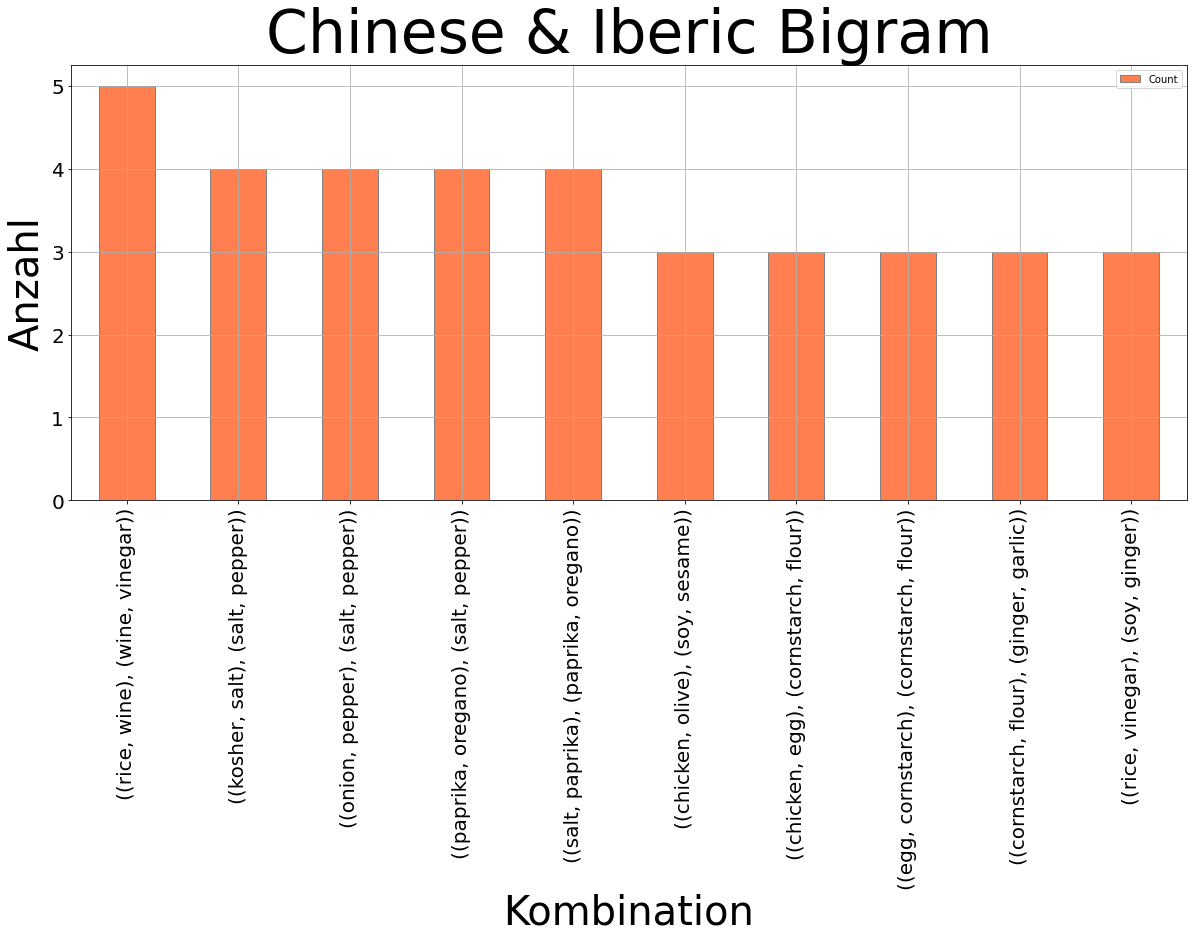

In [41]:
df4.plot.bar(x='Combination',
         y='Count', 
         color=['coral'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey",
         grid= True)

plt.title('Chinese & Iberic Bigram', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination bigram Chinese and Iberic.png', bbox_inches = 'tight')
plt.show()

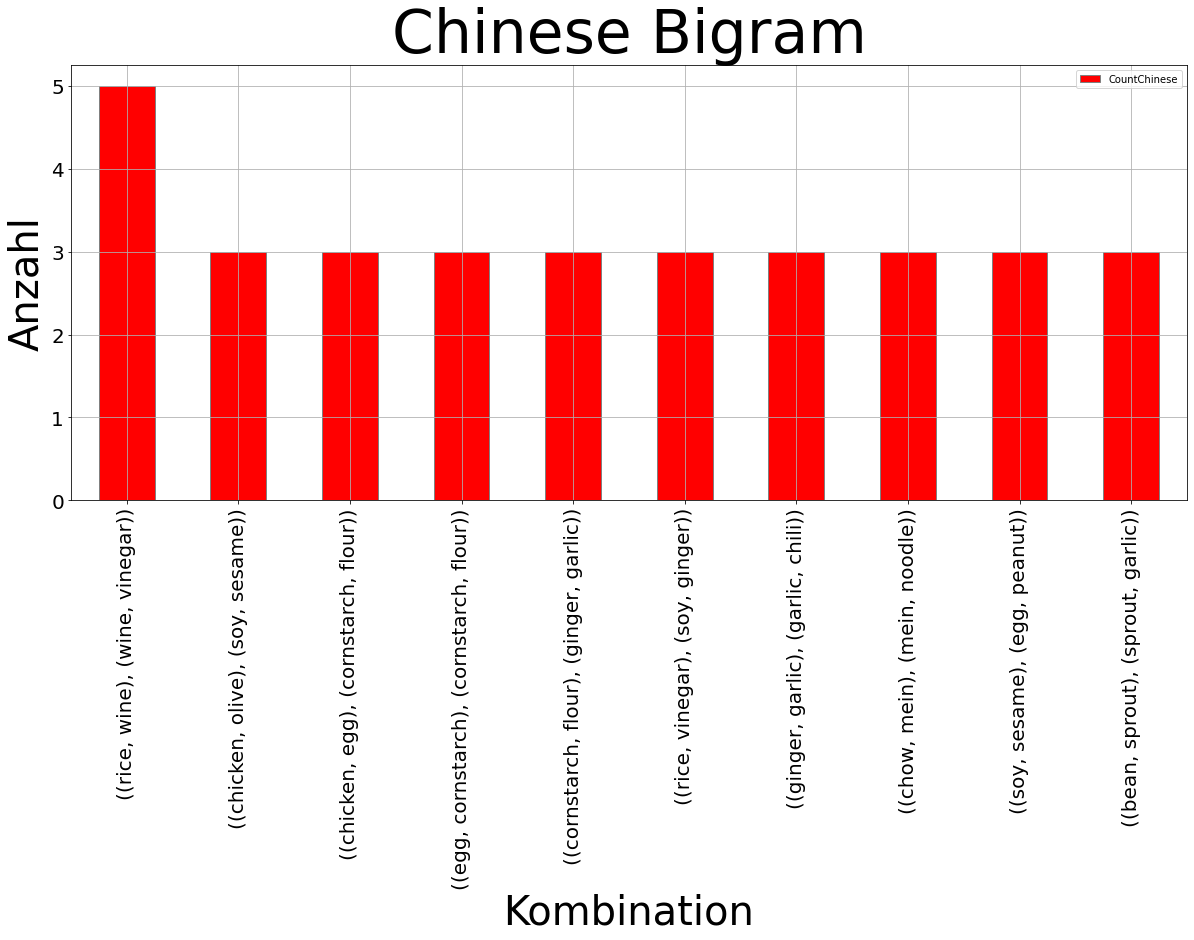

In [42]:
df4c.plot.bar(x='CombinationChinese',
         y='CountChinese', 
         color=['red'],   
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Chinese Bigram', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination bigram Chinese.png', bbox_inches = 'tight')
plt.show()

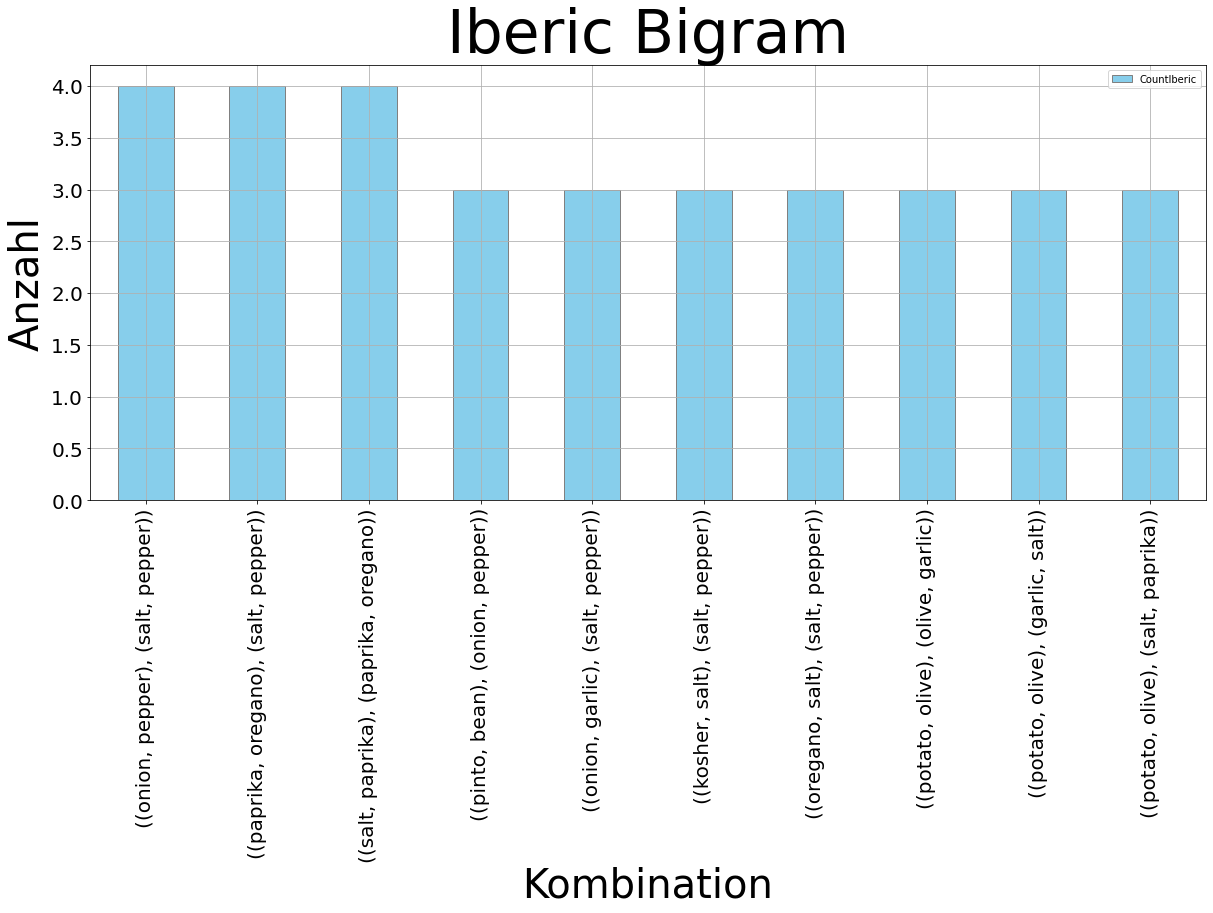

In [43]:
df4i.plot.bar(x='CombinationIberic',
         y='CountIberic', 
         color=['skyblue'],  
         fontsize=20, 
         figsize=(20, 8),
         edgecolor = "grey", 
         grid= True)
plt.title('Iberic Bigram', fontsize=60)
plt.xlabel('Kombination', fontsize=40)
plt.ylabel('Anzahl', fontsize=40)
plt.savefig('Top10 Combination bigram Iberic.png', bbox_inches = 'tight')
plt.show()

# A more intresting way to display data
https://github.com/JasonKessler/scattertext

In [44]:
import string
%matplotlib inline
import scattertext as st
import re, io
from pprint import pprint
import pandas as pd
import numpy as np
from scipy.stats import rankdata, hmean, norm
import spacy
import os, pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer

In [45]:
nlp = spacy.load('en_core_web_sm')

In [46]:
new_df['parsed'] = new_df.cleanText.apply(nlp)
new_df.head(5)

,cuisine,ingredients,ingredients_list,cleanText,cleanTextList,bigrams,number of ingredients,CLEAN number of ingredients,parsed
321,Chinese,"['6 chicken thighs (free range)', '2 tablespoo...","['6 chicken thighs (free range)', '2 tablespo...",chicken olive ginger garlic honey soy sesame,"[chicken, olive, ginger, garlic, honey, soy, s...","[(chicken, olive), (olive, ginger), (ginger, g...",8,7,"(chicken, olive, ginger, garlic, honey, soy, s..."
322,Chinese,"['2 tablespoons butter (divided)', '2 eggs (be...","['2 tablespoons butter (divided)', '2 eggs (b...",butter egg onion carrot pea garlic ginger rice...,"[butter, egg, onion, carrot, pea, garlic, ging...","[(butter, egg), (egg, onion), (onion, carrot),...",11,11,"(butter, egg, onion, carrot, pea, garlic, ging..."
323,Chinese,"['chicken', '4 boneless skinless chicken breas...","['chicken', '4 boneless skinless chicken brea...",chicken chicken egg cornstarch flour sugar ric...,"[chicken, chicken, egg, cornstarch, flour, sug...","[(chicken, chicken), (chicken, egg), (egg, cor...",19,14,"(chicken, chicken, egg, cornstarch, flour, sug..."
324,Chinese,['1 1/2 pounds boneless skinless chicken breas...,['1 1/2 pounds boneless skinless chicken breas...,chicken cornstarch flour baking water salt egg...,"[chicken, cornstarch, flour, baking, water, sa...","[(chicken, cornstarch), (cornstarch, flour), (...",19,18,"(chicken, cornstarch, flour, baking, water, sa..."
325,Chinese,"['1 head broccoli (cut into florets)', '3 tabl...","['1 head broccoli (cut into florets)', '3 tab...",broccoli chicken garlic spring onion ginger ho...,"[broccoli, chicken, garlic, spring, onion, gin...","[(broccoli, chicken), (chicken, garlic), (garl...",12,10,"(broccoli, chicken, garlic, spring, onion, gin..."


In [47]:
corpus = st.CorpusFromParsedDocuments(new_df, category_col='cuisine', parsed_col='parsed').build()
print(corpus)

In [48]:
html = produce_scattertext_explorer(corpus,
                                    category='Iberic',
                                    category_name='Iberic',
                                    not_category_name='Chinese',
                                    width_in_pixels=1200,
                                    minimum_term_frequency=1,
                                    transform=st.Scalers.scale,
                                    metadata=new_df['cuisine'])
file_name = 'scattertext/ChineseIbericCusineScattertextScale.html'
open(file_name, 'wb').write(html.encode('utf-8'))
IFrame(src=file_name, width = 1600, height=800)